# ECE 364 Lecture 20
## Deep Nets (Part 2): Convolutional Neural Networks
### Learning Objectives
After this lecture, students will be able to
* Compare convolutional neural networks (CNN) and multi-layer perceptrons (MLP).
* Describe the relevant parameters of convolutional layers including stride, padding, and kernel size.
* Explain advantages of CNNs with respect to number of parameters and spatial information within data.

## Recap of Multi-layer Perceptrons (MLP)
Last time, we explored Multi-layer Perceptrons (MLP) as our first type of deep learning model. An MLP takes an input vector $x\in\mathbb{R}^N$ and passes the input through a series of $K$ layers. Each layer is composed of multiplication with a weight matrix (affine transformation accounting for bias term) followed by an element-wise non-linear activation function. Let $W_k$ denote the weight matrix at layer $k$ and $\sigma(z)$ be the element-wise non-linear activation function. We express any MLP $f(x)$ as
$$
f_\theta(x) = W_K\sigma(W_{K-1}\sigma(W_{K-2} \cdots W_2\sigma(W_1x))).
$$
$$
\theta = \{W_1, W_2, W_3, \ldots, W_K\}
$$
Thus, for a $K$-layer MLP, we have $K-1$ activation functions and we refer to each of these layers with an activation function as **hidden layers**. Each hidden layer has an output dimension that we may specify. For example, the first layer has matrix $W_1\in\mathbb{R}^{d_1\times N}$ that transforms the input vector from length $N$ to length $d_1$ that we may choose. We refer to these hidden layer dimensions, i.e. $d_1$, $d_2$, $\cdots$, $d_{K-1}$, as the **width** of each layer. Thus, we describe MLPs in terms of the depth (how many layers) and width (the dimensions of the **feature vectors** at each layer).

The use of MLPs allowed us to learn more complex classifiers and thus more complex classification boundaries; for example, separating data in the toy two moons dataset last lecture. We also saw simple MLPs achieve near perfect training accuracy on the more complicated FashionMNIST dataset with fairly strong validation accuracy (around 80% accuracy). In this lecture, we want to improve upon the performance of these MLPs and introduce another popular deep neural network architecture. First, we will consider a motivating example below.

Below, we provide the implementation of the FashionMNIST dataset from the previous lecture as well as a "scrambled" version of this dataset. The scrambled version picks a random permutation to shuffle the pixels in the images of the FashionMNIST dataset to apply to all images, i.e. the pixels are shuffled randomly but in the exact same way for all images.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class FashionMNIST(Dataset):
    def __init__(self):
        self.data = torchvision.datasets.FashionMNIST(root='./',
                                            download=True,
                                            train=True,
                                            transform=transforms.Compose([transforms.ToTensor()]))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image.reshape(-1), label

class ScrambledFashionMNIST(Dataset):
    def __init__(self):
        self.data = torchvision.datasets.FashionMNIST(root='./',
                                            download=True,
                                            train=True,
                                            transform=transforms.Compose([transforms.ToTensor()]))
        
        self.permutation = torch.randperm(len(self.data[0][0].view(-1)))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        # scramble the image
        image = image.reshape(-1)
        image = image[self.permutation]
        return image, label

dataset = FashionMNIST()
scrambled_dataset = ScrambledFashionMNIST()

100%|██████████| 26421880/26421880 [00:03<00:00, 8407069.14it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 261553.59it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4711260.79it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16816415.10it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Text(0.5, 1.0, 'Image of class 7')

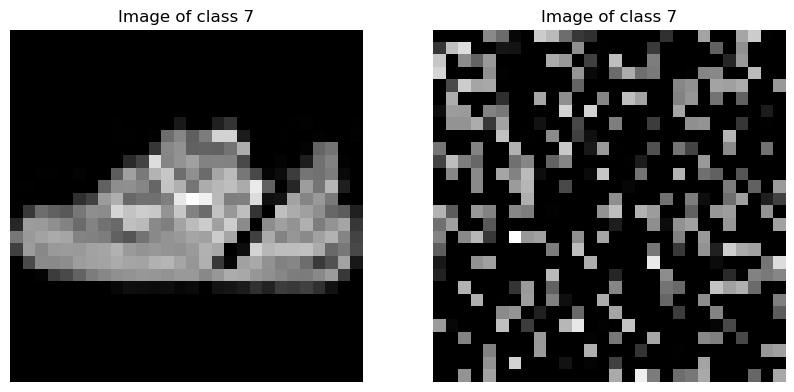

In [3]:
# visualize example images from both datasets
import matplotlib.pyplot as plt
idx = 364
image, label = dataset[idx]
scrambled_image, scrambled_label = scrambled_dataset[idx]

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(image.reshape(28, 28).numpy(), 'gray')
plt.axis(False)
plt.title('Image of class {}'.format(label))
plt.subplot(122)
plt.imshow(scrambled_image.reshape(28, 28).numpy(), 'gray')
plt.axis(False)
plt.title('Image of class {}'.format(scrambled_label))

Clearly, it is impossible for us as humans to discern what article of clothing each of the scrambled images represent. Still, let's see how a given simple MLP is able to perform the classification task presented by FashionMNIST in both the original and scrambled versions.

In [4]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm

class ThreeLayerMLP(nn.Module):
    def __init__(self, input_dim, h1, h2, output_dim, activation_fn):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1) # first fully-connected layer
        self.fc2 = nn.Linear(h1, h2) # second fully-connected layer
        self.fc3 = nn.Linear(h2, output_dim) # output layer
        self.activation = activation_fn

    def forward(self, x):
        x = self.activation(self.fc1(x)) # first layer
        x = self.activation(self.fc2(x)) # second layer
        z = self.fc3(x) # output layer
        return z

def training_loop(model, criterion, optimizer, n_epochs, train_loader, val_loader):
    loss_values, train_accuracies, val_accuracies = [], [], []
    for n in tqdm(range(n_epochs)):
        epoch_loss, epoch_acc = 0, 0
        for x_batch, y_batch in train_loader:
            # zero out gradients
            optimizer.zero_grad()
            # pass batch to model
            predictions = model(x_batch)
            # calculate loss
            loss = criterion(predictions, y_batch)
            # backpropagate and update
            loss.backward() # backprop
            optimizer.step()
            # logging to update epoch_loss (add loss value) and epoch_acc (add current batch accuracy)
            epoch_loss += loss.item()
            epoch_acc += multiclass_model_accuracy(model, x_batch, y_batch)
    
        loss_values.append(epoch_loss/len(train_loader))
        train_accuracies.append(epoch_acc/N_train)
        # validation performance
        val_acc = 0
        for x_batch, y_batch in val_loader:
            # don't compute gradients since we are only evaluating the model
            with torch.no_grad():
                # validation batch accuracy
                val_acc += multiclass_model_accuracy(model, x_batch, y_batch)
        val_accuracies.append(val_acc/N_val)
    return model, loss_values, train_accuracies, val_accuracies

def multiclass_model_accuracy(model, input_data, labels):
    predictions = model(input_data) # no need to squeeze/unsqueeze dimensions now!
    predicted_classes = torch.argmax(predictions, dim=1) # find highest scoring class along the columns
    n_correct = torch.sum(torch.eq(predicted_classes, labels))
    return n_correct

100%|██████████| 300/300 [01:03<00:00,  4.74it/s]


Text(0.5, 0, 'Epoch')

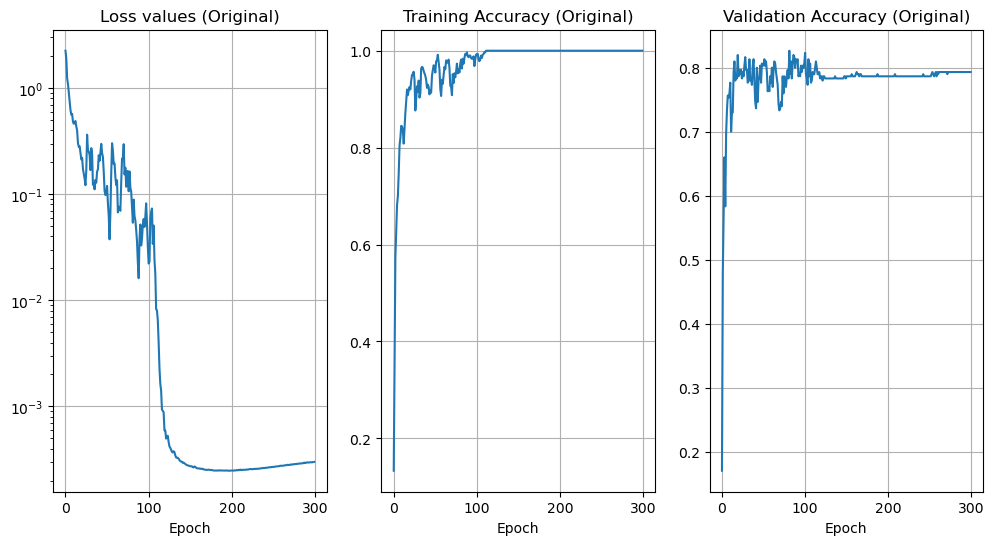

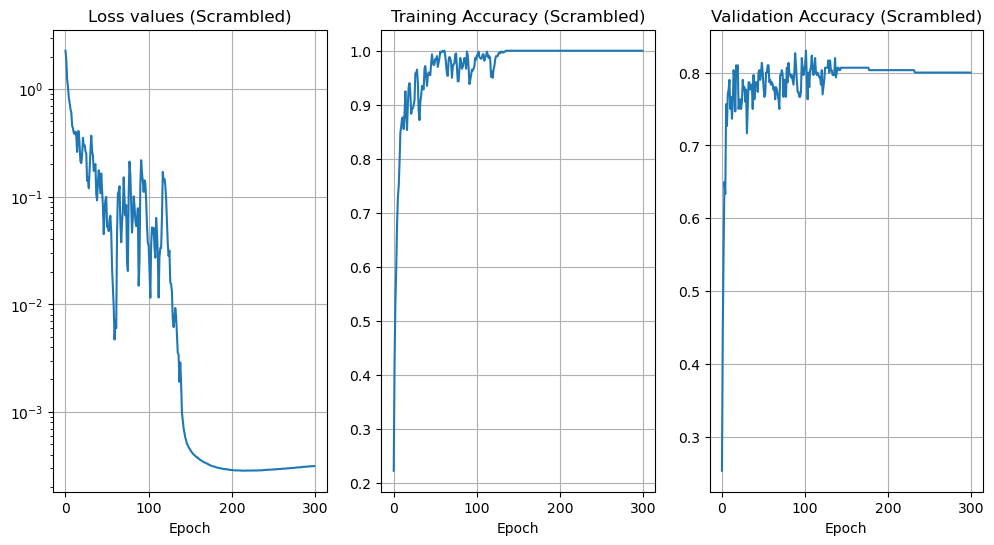

In [5]:
# set up data
N = 1000
N_train = 600
N_val = 300
N_test = 100
dataset = FashionMNIST()
scrambled_dataset = ScrambledFashionMNIST()
indices = np.random.choice(np.arange(len(dataset)), size=N, replace=False)
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]
test_indices = indices[N_train+N_val]

# create separate dataloaders for regular and scrambled datasets, but they still use the same images!
batch_size = 8
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
scrambled_train_loader = DataLoader(scrambled_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
scrambled_val_loader = DataLoader(scrambled_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

# initialize model for each dataset
input_dim = 784 # dimension of images after being vectorized
h1 = 128
h2 = 64
output_dim = 10 # number of classes
activation_fn = nn.ReLU()
model = ThreeLayerMLP(input_dim, h1, h2, output_dim, activation_fn)
scrambled_model = ThreeLayerMLP(input_dim, h1, h2, output_dim, activation_fn)

# initialize loss function and optimizers for each dataset
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-4)
scrambled_optimizer = torch.optim.SGD(scrambled_model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-4)

# train each model on their respective datasets
n_epochs = 300
model, losses, train_accs, val_accs = training_loop(model, criterion, optimizer, n_epochs, train_loader, val_loader)
scrambled_model, s_losses, s_train_accs, s_val_accs = training_loop(scrambled_model, criterion, scrambled_optimizer,
                                                                    n_epochs, scrambled_train_loader, scrambled_val_loader)

# original dataset results
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.semilogy(losses)
plt.grid(True)
plt.title('Loss values (Original)')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accs)
plt.grid(True)
plt.title('Training Accuracy (Original)')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accs)
plt.grid(True)
plt.title('Validation Accuracy (Original)')
plt.xlabel('Epoch')

# scrambled dataset results
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.semilogy(s_losses)
plt.grid(True)
plt.title('Loss values (Scrambled)')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(s_train_accs)
plt.grid(True)
plt.title('Training Accuracy (Scrambled)')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(s_val_accs)
plt.grid(True)
plt.title('Validation Accuracy (Scrambled)')
plt.xlabel('Epoch')

The above results are effectively the same! Of course, there may be minor variations do to random initialization of the models and stochastic effects with sampling different random batches to train each model. But their final loss values and accuracies are close enough that we cannot say the MLP model cares about whether the data is scrambled or visually logical. Furthermore, the above three-layer model contains a rather large number of parameters.
$$
\begin{align}
\textrm{Layer 1} &= 784\times 128 + 128 = 100,\!480\textrm{ parameters}\\
\textrm{Layer 2} &= 128\times 64 + 64 = 8,\!256\textrm{ parameters}\\
\textrm{Layer 3} &= 64\times 10 + 10 = 650\textrm{ parameters}\\
\textrm{Total} &= 109,\!386\textrm{ parameters}
\end{align}
$$

Just a simple three-layer MLP contains on the order of 100,000 parameters! Now consider that modern deep nets may have tens or hundreds of layers and that we may process images that are much larger like $256\times 256$ or $1024\times 1024$ and in RGB. Thus, MLPs have two clear shortcomings:

1. Spatial information is not considered as all entries of the input are processed with no respect for which entries are closer to other. In other words, MLPs are **permutation-invariant** as we may shuffle input data and obtain the same result of model training as we saw with FashionMNIST above.
2. They are parameter inefficient and quickly require enormous numbers of trainable parameters for larger inputs or deeper models.

We will now look to identify a deep learning architecture that remedies these two issues by (1) utilizing spatial information at each layer and (2) not having the number of parameters scale with the size of the input data. The solution we will identify is going to rely on the fundamental operation of **convolution**, which we will briefly overview in the next section.

## Brief Overview of Convolution

Prior knowledge regarding convolution may vary from student to student, so we will try to provide a concise explanation of convolution that does not require much pre-requisite experience. In ECE 210, we define convolution for continuous time signals $x(t)$ and $h(t)$ as
$$
y(t)=x(t)*h(t)=\int_{-\infty}^{\infty}x(\tau)h(t-\tau)d\tau.
$$

Conceptually, for each point in time $t$, we choose one signal to reverse in time and shift by $t$. At that particular flip-and-shift location $h(-(\tau-t))$, we integrate the product of $x(\tau)h(-(\tau-t))$ with respect to $\tau$. Moving to discrete-time signals $x[n]$ and $h[n]$, we have a similar definition for convolution:
$$
y[n] = x[n]*h[n]=\sum_{k=-\infty}^{\infty}x[k]h[n-k].
$$

Again, we reverse one signal and shift by $n$ samples in this case. The result at time index $n$ is then the summation over all indices $k$ of the product $x[k]h[-(k-n)]$. We see then that discrete-time convolution is quite similar to continuous-time convolution where we now a discrete time variable and a summation over all time replaces an integral over all time.

The below figure gives an example of convolving $x[n]=\{2, 1, -3, 0, 4\}$ with $h[n]=\{1, 0, -1\}$ where the final result is $y[n]=\{2, 1, -5, -1, 7, 0, -4\}$.

<div>
<center><img src="1d-convolution-example.png" width="600"/> </center>
</div>

Intuitively, at each shift location, convolution computes the dot product between the shifted signal and the subset of the stationary signal it overlaps with. Thus, convolution is performing a sort of **template matching** where we assess the similarity between the shifting signal against each local portion of the stationary signal. 

Moving to higher dimensions, convolution proceeds in the same manner where one signal is kept stationary while the other signal is flipped and shifted around. Let $X[i, j]\in\mathbb{R}^{H\times W}$ be an image with height $H$ and width $W$ and $H[i, j]\in\mathbb{R}^{K\times K}$ be a 2D **convolutional kernel** or **filter** of size $K\times K$. Formally, the convolution $Y[i, j]=X[i,j]*H[i,j]$ is given by
$$
Y[i, j] = \sum_{k_1=0}^{H-1}\sum_{k_2=0}^{W-1}X[k_1, k_2]H[i-k_1, j-k_2].
$$
However, in practice, we do not worry about flipping the convolutional kernel since we may simply view the filters we learn as being flipped versions of the proper filter. In practice, 2D convolution looks the same as 1D convolution except we must shift in two dimensions and sum the elementwise product between the filter and the image at each shift location. The below GIF depicts the convolution of an image and filter as follows:
$$
X[i, j] = \begin{bmatrix}
3 & 3 & 2 & 1 & 0\\
0 & 0 & 1 & 3 & 1\\
3 & 1 & 2 & 2 & 3\\
2 & 0 & 0 & 2 & 2\\
2 & 0 & 0 & 0 & 1
\end{bmatrix}\quad
H[i, j]=\begin{bmatrix}
0 & 1 & 2\\
2 & 2 & 0\\
0 & 1 & 2
\end{bmatrix}
$$

<div>
<center><img src="PyTorch-Conv-2D-Example.gif" width="500"/></center>
</div>

## Convolutional Neural Networks (CNN)
In the above depiction of 2D convolution, we observe two things. First, the size of the filter $H$ does not need to scale with the size of the input image $X$. Second, the use of convolution promotes spatial coherence in the resulting output. Thus, each entry in the output represents spatially meaningful information about the previous input. This suggests that we may consider replacing the fully-connected operators of multi-layer perceptrons with convolution operators for learning parameters in a machine learning model. As such, we may define a new type of model denoted by

$$
f_\theta(x) = H_K*\sigma(H_{K-1}*\sigma(H_{K-2} \cdots H_2*\sigma(H_1*x)))
$$
$$
\theta = \{H_1, H_2, H_3, \ldots, H_K\},
$$
where each convolution operator $H_k\in\mathbb{R}^{C_{\textrm{out}}\times K_1\times K_2\times C_{\textrm{in}}}$ has a specified number of input channels, output channels, and kernel dimensions in both height and width given by $K_1$ and $K_2$, respectively. All these different dimensions can be confusing, so let's unpack what we mean by input and output channels as well as how we convolve along input channels in a given input image or **feature map**. The below figure depicts a convolutional layer with 3 input channels, 2 output channels, and kernel size of $3\times 3$. For each convolutional kernel, we have a stack of 3 *independent and unique* $3\times 3$ filters. Convoling each kernel with the $3$-channel input image produces one 2D feature map. We also have 2 independent convolutional kernels; thus, the result of the entire convolutional layer has 2 equal-sized feature maps or **feature channels**.

<div>
<center><img src="convolution-with-multiple-filters2.png" width="800"/></center>
</div>

Altogether, a convolutional layer (ignoring bias terms) has $C_{\textrm{out}}\times K_1\times K_2\times C_{\textrm{in}}$ learnable parameters. Typical choices of $K_1$ and $K_2$ are relatively small odd numbers, e.g. 3, 5, and 7, and we often keep kernels square, i.e. $K_1=K_2$. The number of input and output channels is a design choice we may make at intermediate layers, while the input layer will have the nubmer of input channels determined by the image modality, e.g. 3 input channels for RGB images and 1 input channel for grayscale images.

We refer to these deep learning models that utilize convolutional layers as **convolutional neural networks** (CNN). Before creating a CNN and applying it to the FashionMNIST dataset, we should define some other key terminology and practices for CNNs. First, each convolutional layer has multiple parameters that must be set. The most important of these parameters are stride, padding, and kernel size.
* **stride**: The stride of a convolutional layer determines how much the filter shifts between subsequent each elementwise product. The default choice would simply be one as we define in basic convolution. However, we may choose a stride of two, three, etc. in order to reduce the size of the resulting feature map. For example, increasing the stride from one to two will result in a feature map that is half as tall and half as wide as the input.

* **padding**: The above examples demonstrate no padding as the convolutional kernels are not allowed to hang off the edge of the input image. The padding value determines how many zero-valued pixels are padded around the edge of the input image. We commonly choose a padding size of $\frac{K-1}{2}$ for odd-sized square kernels of size $K$ so that output feature maps match the size of input feature maps. This choice results in the convolutional kernel as being effectively "centered" at each location in the input image to produce the result at the same location in the output feature maps.

* **kernel size**: As previously mentioned, we may choose the size of the convolutional kernels at each layer and the size may be rectangular or square. The most common choices are relatively small, square, and odd-sized kernels, e.g. $3\times 3$, $5\times 5$, $7\times 7$.

For an input image $X\in\mathbb{R}^{C_{\textrm{in}}\times H_{\textrm{in}} \times W_\textrm{in}}$ and convolutional layer with stride $s$, padding $p$, and kernel size $K_H\times K_W$, the resulting height $H_\textrm{out}$ and width $W_\textrm{out}$ of the output feature maps will be
$$
\begin{align}
H_\textrm{out} &= \left\lfloor\frac{H_{\textrm{in}}+2p-(K_H-1)-1}{s}+1\right\rfloor\\
W_\textrm{out} &= \left\lfloor\frac{W_{\textrm{in}}+2p-(K_W-1)-1}{s}+1\right\rfloor.
\end{align}
$$

### Pooling Layers
Setting the stride and padding parameters is one way to reduce the size of subsequent features maps. Reducing the size of feature maps makes CNNs less computationally expensive as adjacent values in feature maps are often redundant. Another popular technique is the use of **pooling layers**. A pooling layer has its own kernel size and stride parameters used to mask out windows of feature maps. Within each of these windows, a simple function is applied to the elements of each feature map within the window. The kernel size and stride are commonly set to be equal; thus, the pooling operation tiles each feature map into non-overlapping segments. 

The two most common forms of pooling layers are **mean pooling** and **max pooling**. As the names suggest, mean pooling computes the mean of each window while max pooling takes the maximum value within each window. The below example depicts $2\times 2$ max pooling for a single feature channel.

<div>
    <center><img src="MaxpoolSample2.png", width="600"/></center>
</div>

### Classification Heads
Finally, after all of the convolutional layers in a CNN, we still need some mechanism for computing final class scores (respectively other scores for other machine learning tasks, e.g. regression). Suppose $Z_K\in\mathbb{R}^{C\times H\times W}$ is the final set of feature maps in a CNN with $C$ channels and size $H\times W$. One popular approach is to apply **global average pooling** or **global max pooling** to reduce each feature channel to a single value. Thus,
$$
\textrm{GlobalPooling}(Z_k)\in\mathbb{R}^{C}
$$
produces a length-$C$ vector. From here, a simple fully-connected layer with weight matrix $W\in\mathbb{R}^{M\times C}$ (effectively a logistic regression model) may produce class scores for the $M$ classes.

### Summary of Common CNN Structure for Classification
In summary, a CNN for classification tasks is typically composed of convolution layers that are followed by non-linear activation functions just like we saw with MLP models. We commonly stack some number of convolution layers before appling a poolying layer, e.g. max pooling. After some number of blocks alternating convolution layers and pooling layers, we apply a global pooling operation, e.g. global max pooling, to reduce the feature maps at the last layer to a single value and thus produce a vector of feature values. Finally, we may produce class scores by applying a fully-connected layer to the feature values from the global pooling layer

For example, we may construct a 5-layer CNN as follows for input RGB images of size $H\times W$ as follows:

<div>
    <center><img src="five-layer-cnn.png" width="1000"/></center>
</div>

The below code implements this 5-layer CNN using the [``nn.Conv2d`` function](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for 2D convolution, [``nn.MaxPool2d`` function](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) for 2D max-pooling, and the [``nn.AdaptiveAvgPool2d`` function](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) with the output size set to $(1, 1)$ to perform global average pooling.

## Lecture Exercise 1: Examining a Small CNN

a) Consider the below five-layer CNN that implements the above figure of a CNN. Suppose the input data is $X\in\mathbb{R}^{3\times 28\times 28}$ and the ground-truth labels are over $M=5$ possible classes. Determine the shape of each feature map $Z_1$, $Z_2$, $Z_3$, and $Z_4$.

$$
\begin{align}
Z_1&\in\mathbb{R}^{16\times 14\times 14}\\
Z_2&\in\mathbb{R}^{32\times 7\times 7}\\
Z_3&\in\mathbb{R}^{64}\\
Z_4&\in\mathbb{R}^{5}\\
\end{align}
$$

b) Determine the number of parameters in each layer (all five convolutional layers and one fully connected layers) and the resulting total number of parameters. You may assume no bias terms in the convolutional layers.

$$
\begin{align}
\textrm{Convolutional Layer 1}&=3\times 16\times 3\times 3=432\\
\textrm{Convolutional Layer 2}&=16\times 16\times 3\times 3=2,\!304\\
\textrm{Convolutional Layer 3}&=16\times 32\times 5\times 5=12,\!800\\
\textrm{Convolutional Layer 4}&=32\times 32\times 5\times 5=25,\!600\\
\textrm{Convolutional Layer 5}&=32\times 64\times 3\times 3=18,\!432\\
\textrm{Fully Connected Layer}&=64\times 5 + 5=325\\\\
\textrm{Total Parameters}&=59,\!893\\
\end{align}
$$

In [5]:
import torch
import torch.nn as nn

class FiveLayerCNN(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1, stride=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2, stride=1, bias=False)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, bias=False)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2) # max pooling layer
        self.global_pooling = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # global pooling layer
        self.activation_fn = nn.ReLU()
        self.fc = nn.Linear(64, n_classes, bias=True)

    def forward(self, x):
        print('Input is shape: {}'.format(x.shape))
        B = x.size(0) # B is the batch size or number of examples passed to the model
        x = self.activation_fn(self.conv1(x))
        x = self.activation_fn(self.conv2(x))
        z1 = self.pooling(x)
        z1 = self.activation_fn(self.conv3(z1))
        z1 = self.activation_fn(self.conv4(z1)) 
        z2 = self.pooling(z1)
        z2 = self.activation_fn(self.conv5(z2))
        z3 = self.global_pooling(z2).view(B, -1) # make sure feature maps for each input image are vectorized
        z4 = self.fc(z3)
        print('Result after max pooling stage 1 is shape: {}'.format(z1.shape))
        print('Result after max pooling stage 2 is shape: {}'.format(z2.shape))
        print('Result after global average pooling is shape: {}'.format(z3.shape))
        print('Result after global average pooling is shape: {}'.format(z4.shape))
        return z4

in_channels = 3
n_classes = 5
model = FiveLayerCNN(in_channels, n_classes)
print(model)

B = 2 # batch size
H, W = 28, 28
input_data = torch.rand(B, in_channels, H, W)
with torch.no_grad():
    class_scores = model(input_data)

print('Conv 1 Parameters: {}'.format(torch.numel(model.conv1.weight)))
print('Conv 2 Parameters: {}'.format(torch.numel(model.conv2.weight)))
print('Conv 3 Parameters: {}'.format(torch.numel(model.conv3.weight)))
print('Conv 4 Parameters: {}'.format(torch.numel(model.conv4.weight)))
print('Conv 5 Parameters: {}'.format(torch.numel(model.conv5.weight)))
print('Fully Connected Parameters: {}'.format(torch.numel(model.fc.weight)+torch.numel(model.fc.bias)))

FiveLayerCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pooling): AdaptiveAvgPool2d(output_size=(1, 1))
  (activation_fn): ReLU()
  (fc): Linear(in_features=64, out_features=5, bias=True)
)
Input is shape: torch.Size([2, 3, 28, 28])
Result after max pooling stage 1 is shape: torch.Size([2, 32, 14, 14])
Result after max pooling stage 2 is shape: torch.Size([2, 64, 7, 7])
Result after global average pooling is shape: torch.Size([2, 64])
Result after global average pooling is shape: torch.Size([2, 

## Lecture Exercise 2: Revisiting Fashion MNIST

Now we will finally revisit our earlier experiments on FashionMNIST now equipped with CNNs

a) Fill in the below ``MyCNNModel`` code to create your own CNN.

b) Run your CNN model on the FashionMNIST using the provided training and evaluation code below. Try choosing different numbers of layers (not too many, e.g. no more than 6), different type of pooling functions, different convolution layer parameters (number of feature channels, kernel size, stride, etc.) in your model to observe which design choices improve model performance.

**Note** Your model may take a few minutes to train on each dataset. Alternatively, make your model shallower with fewer feature channels or have larger choices of stride in convolutional or pooling layers to speed up computation.

In [6]:
# fill this in!
class MyCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.pooling = nn.MaxPool2d(stride=2, kernel_size=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.activation = nn.ReLU()
        self.fc = nn.Linear(128, 10)
    
    def forward(self, x):
        B = x.size(0)
        x = self.activation(self.conv1(x))
        x = self.pooling(x)
        x = self.activation(self.conv2(x))
        x = self.pooling(x)
        x = self.activation(self.conv3(x))
        x = self.gap(x).view(B, -1)
        z = self.fc(x)
        return z 

In [7]:
# 2D version of Fashion MNIST datasets
class FashionMNIST2D(Dataset):
    def __init__(self):
        self.data = torchvision.datasets.FashionMNIST(root='./',
                                            download=True,
                                            train=True,
                                            transform=transforms.Compose([transforms.ToTensor()]))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:01<00:00,  1.21s/it]


Text(0.5, 0, 'Epoch')

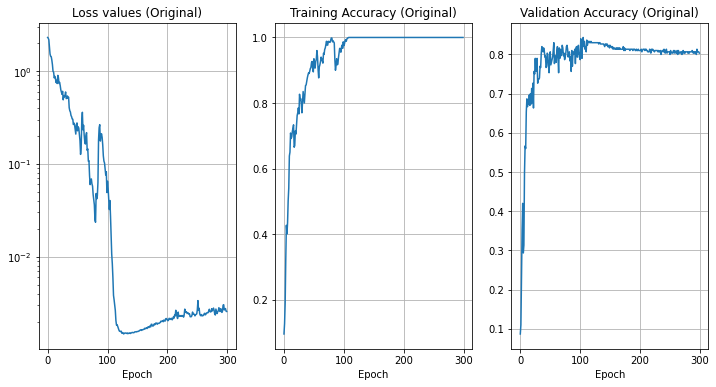

In [8]:
import numpy as np

# set up data
N = 1000
N_train = 600
N_val = 300
N_test = 100
dataset = FashionMNIST2D()
indices = np.random.choice(np.arange(len(dataset)), size=N, replace=False)
np.random.shuffle(indices)
train_indices = indices[:N_train]
val_indices = indices[N_train:N_train+N_val]
test_indices = indices[N_train+N_val]

# create separate dataloaders for regular and scrambled datasets, but they still use the same images!
batch_size = 8
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

# initialize model for each dataset
model = MyCNNModel()

# initialize loss function and optimizers for each dataset
criterion = nn.CrossEntropyLoss()
lr = 3e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=1e-4)

# train each model on their respective datasets
n_epochs = 300
model, losses, train_accs, val_accs = training_loop(model, criterion, optimizer, n_epochs, train_loader, val_loader)

# original dataset results
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.semilogy(losses)
plt.grid(True)
plt.title('Loss values (Original)')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accs)
plt.grid(True)
plt.title('Training Accuracy (Original)')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accs)
plt.grid(True)
plt.title('Validation Accuracy (Original)')
plt.xlabel('Epoch')